# Going For It

This project investigates using the 2020 season's data, whether the Green Bay Packers should have gone for it on their 4th and Goal vs the Tampa Bay Buccaneers.

Trailing 31-23, Green Bay were left with a 4th and 8, with under 2 minutes remaining. With soon to be crowned MVP, and all-time great QB, Aaron Rodgers, at the helm, Green Bay coach Matt LeFluer opted to kick a field goal, and make a stop. 

Tampa go on to win the game, and then the Superbowl. The decision to opt for a field-goal was debated to the n-th degree, with Rodgers stating after the game 'I understand the thinking, but it wasn’t my decision'. Statements like this lead to a Summer of unrest. This was alleviated with another MVP level season, and another number 1 seed by the Packers.



# Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Importing and Inspecting the Data

In [18]:
data = pd.read_csv('play_by_play_2020.csv')

all_plays_2020 = data[['game_id','posteam', 'defteam', 'yardline_100',
                        'down', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained',
                        'pass_length', 'pass_location', 'air_yards','first_down_rush',
                        'first_down_pass', 'incomplete_pass', 'interception','rush_attempt',
                        'pass_attempt', 'touchdown', 'passer_player_id','passer_player_name',
                        'receiver_player_id','receiver_player_name', 'receiving_yards',
                        'rusher_player_id', 'rusher_player_name', 'rushing_yards', 'series_success',
                        'series_result', 'play_type_nfl']]

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
print(all_plays_2020.head(5))

          game_id posteam defteam  yardline_100  down  ydstogo  ydsnet  \
0  2020_01_ARI_SF     NaN     NaN           NaN   NaN        0     NaN   
1  2020_01_ARI_SF      SF     ARI          35.0   NaN        0    41.0   
2  2020_01_ARI_SF      SF     ARI          75.0   1.0       10    41.0   
3  2020_01_ARI_SF      SF     ARI          55.0   1.0       10    41.0   
4  2020_01_ARI_SF      SF     ARI          41.0   1.0       10    41.0   

  play_type  yards_gained pass_length  ... passer_player_name  \
0       NaN           NaN         NaN  ...                NaN   
1   kickoff           0.0         NaN  ...                NaN   
2      pass           5.0       short  ...        J.Garoppolo   
3       run          14.0         NaN  ...                NaN   
4       run           2.0         NaN  ...                NaN   

   receiver_player_id  receiver_player_name  receiving_yards  \
0                 NaN                   NaN              NaN   
1                 NaN               

play_by_play_2020 is a file that I found online that someone scraped from the nfl plays python library. It contains all of the plays of the 2020 season.

For all_plays_2020 I picked the columns which I thought may be relevant to conduct my test:

## Column Descriptions

* game_id - individual identifier for each game
* posteam - team in possesion for the play
* defteam - team defending for the play
* yrdline100 - which yardline ball is on in respect to the whole field - 1-100
* down - Which down is being played
* ydstogo - Yards needed for a first down
* ydsnet - net gain/loss of yards for play
* play_type - Type of play
* yards_gained - Amount of yards gained
* pass_length - Short or deep
* pass_location - Left,right, middle
* air_yards - Distance ball traveled in the air
* first_down_rush - ran for a first down 0/1
* first_down_pass - passed for a first down 0/1
* incomplete_pass - pass was not completed 0/1
* intercept - pass was intercepted
* rush_attempt - Was it a rushing play (Yes/No)
* pass_attempt - Was a pass attempted (Yes/No)
* touchdown - Touchdown scored (Yes/No)
* passer_player_id - Individual id for each passer
* passer_player_name - Name of passer
* receiver_player_id - Individual id for each pass catcher
* receiver_player_name - Name of pass catcher
* receiving_yards - Receiving yards for play
* rusher_player_id - Individual id for each rusher
* rusher_player_name - Name of rusher
* rushing_yards - Receiving yards for play
* series_success - Was the series a success 1/0
* series_result - First Down, Touchdown or Punt


# Sorting the Data

This data set is obviously massive, so I needed to trim it down now

So first of all I trim the dataset to just plays that are from the Packers.

In [8]:
# Filtering Data to just Green Bay

GB_plays = all_plays_2020['posteam'] == 'GB'
GB_2020 = all_plays_2020[GB_plays]

The Packers were situated on the 8 yard line when they kicked the goal, meaning that a play less than 8 yards would have been a failure, while a play or more than 18 would have been a failure also, as the endzone is only 10 yards long. So, next I filtered plays out that went more than 18 yards.

In [9]:
# Removing plays that went for > 18 yards
GB_2020 = GB_2020[GB_2020['yards_gained'].between(0, 18)]

For this analysis, I decided to choose only plays where the Packers required at least 8, and less than 18 yards. This may have been a bit restrictive but I wanted to remove plays where they may have only been looking for a 2/3 yard gain, and a broke tackle lead to a 60 yard touchdown. 

In [10]:
# Removing plays that were under 8 yards needed and more than 18
GB_2020 = GB_2020[GB_2020['ydstogo'].between(8, 18)]

Finally, I removed plays that were not passes or runs, as punts or kick off's were not relevant.

In [12]:
# Removing plays that are not passes or runs
GB_2020 = GB_2020[(GB_2020['play_type'] == 'pass') | (GB_2020['play_type'] == 'run')]

print(GB_2020.head(10))
print(GB_2020.shape)

            game_id posteam defteam  yardline_100  down  ydstogo  ydsnet  \
748  2020_01_GB_MIN      GB     MIN          75.0   1.0       10    63.0   
749  2020_01_GB_MIN      GB     MIN          73.0   2.0        8    63.0   
751  2020_01_GB_MIN      GB     MIN          64.0   1.0       10    63.0   
753  2020_01_GB_MIN      GB     MIN          52.0   1.0       10    63.0   
755  2020_01_GB_MIN      GB     MIN          36.0   1.0       10    63.0   
757  2020_01_GB_MIN      GB     MIN          25.0   1.0       10    63.0   
760  2020_01_GB_MIN      GB     MIN          12.0   3.0       12    63.0   
773  2020_01_GB_MIN      GB     MIN          75.0   1.0       10    74.0   
774  2020_01_GB_MIN      GB     MIN          61.0   1.0       10    74.0   
778  2020_01_GB_MIN      GB     MIN          25.0   1.0       10    74.0   

    play_type  yards_gained pass_length  ... passer_player_name  \
748       run           2.0         NaN  ...                NaN   
749       run           4.0  

So after inspecting the data, there are 585 rows to play with

# Adding Integer Based Columns

To use the Linear Regression formula later, the columns used cannot be strings. So in this next section I added new columns which used current columns, to provide these integers. These columns are as follows:

* receiving_success - If receiving yards >= 8 (already removed more than 18 yard plays) [1/0]
* rushing_success - If rushing yards >= 8 ... [1/0]
* successful_play - If a rush or pass went over 8 yards
* play_type_int - Setting a pass to be 1, and a rush to be 0
* defense - Buccs were set to 1, and everyone else to a 0
* rusher_player_id - Giving players that played in this game an integer value, Aaron Jones-1, Jamaal Williams - 2 ,AJ Dillon - 3, Aaron Rodgers-4, 0 if the play wasnt a rush
* receiver_player_id - Giving players that played in this game an integer value, Adams-1, Valdes-Scantling-2, Jones-3, Lazard-5, Williams-6,Lewis-7,Dillon-8, St.Brown-9,Tonyan-10. If play wasnt pass then 0


In [13]:
# Passes under 8 yards won't be enough, so they will be given a 0 and > 8 will be given a 1
GB_2020['receiving_success'] = np.where(GB_2020['receiving_yards'] >= 8, 1, 0)

# Runs under 8 yards won't be enough, so they will be given a 0 and > 8 will be given a 1
GB_2020['rushing_success'] = np.where(GB_2020['rushing_yards'] >= 8, 1, 0)

# Where either one is a successful value
GB_2020['successful_play'] = np.where((GB_2020['rushing_success'] == 1) | (GB_2020['receiving_success'] == 1),1,0)

# Setting the plays into integer values
GB_2020['play_type_int'] = np.where(GB_2020['play_type'] == 'pass',1,0)

# Setting all other teams to 0 and the Buccs to 1
GB_2020['defense'] = np.where(GB_2020['defteam'] == 'TB', 1, 0)

# Changing GB rushers to integers
GB_2020['rusher_player_id'] = GB_2020['rusher_player_id'].fillna(0)
GB_2020["rusher_player_id"].replace({"00-0033293": 1, "00-0033948": 2,
                                     "00-0036265": 3, "00-0023459": 4}, inplace=True)

#Dropping rushers who did not have a play vs Buccs
values = ["00-0032404", "00-0035161", "00-0034272", "00-0034995", "00-0035480"]
GB_2020 = GB_2020[GB_2020.rusher_player_id.isin(values) == False]
print(GB_2020[['rusher_player_name','rusher_player_id']].value_counts())

# Changing GB receivers to integers for players who received a pass in that game
GB_2020['receiver_player_id'] = GB_2020['receiver_player_id'].fillna(0)
GB_2020["receiver_player_id"].replace({"00-0031381": 1, "00-0034272": 2,
                                       "00-0033293": 3, "00-003375": 4,
                                       "00-0034521": 5, "00-0033948": 6,
                                       "00-0024243": 7, "00-0036265":8,
                                       "00-0034279": 9, "00-0033757": 10}, inplace=True)

#Dropoping receivers who did not have a play vs Buccs
values_rec = ["00-0032404", "00-0035671", "00-0035181", "00-0035480", "00-0036456", "00-0030525", "00-0036332", '00-0025580']
GB_2020 = GB_2020[GB_2020.receiver_player_id.isin(values_rec) == False]
print(GB_2020[['receiver_player_id', 'receiver_player_name']].value_counts())


rusher_player_name  rusher_player_id
A.Jones             1                   123
J.Williams          2                    80
A.Dillon            3                    35
A.Rodgers           4                    11
dtype: int64
receiver_player_id  receiver_player_name
1                   D.Adams                 88
2                   M.Valdes-Scantling      44
3                   A.Jones                 35
10                  R.Tonyan                35
5                   A.Lazard                26
6                   J.Williams              19
7                   M.Lewis                 11
9                   E.St. Brown             10
8                   A.Dillon                 3
dtype: int64


# Defining Features and Success for the Test


In [14]:
# Select the desired features
features = GB_2020[["defense", "play_type_int", "rusher_player_id", "receiver_player_id",
                    "yardline_100", "down", "ydstogo"]]
print(features.head())

# Define Success
touchdown = GB_2020['successful_play']
print(touchdown)

     defense  play_type_int rusher_player_id receiver_player_id  yardline_100  \
748        0              0                1                  0          75.0   
749        0              0                1                  0          73.0   
751        0              1                0                  3          64.0   
753        0              1                0                  1          52.0   
755        0              1                0                  5          36.0   

     down  ydstogo  
748   1.0       10  
749   2.0        8  
751   1.0       10  
753   1.0       10  
755   1.0       10  
748      0
749      0
751      0
753      0
755      1
        ..
48305    0
48306    1
48308    0
48309    0
48310    0
Name: successful_play, Length: 541, dtype: int64


# Performing Test Train Split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    touchdown,
    test_size = 0.2,
    random_state = 1)

# Normalising the Data

In [19]:
# Normalising the data, so it has a mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and Training the Model

In [20]:
# Create and train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

print(model.score(X_test_scaled, y_test))

0.6972477064220184


So this means that the model has an accuracy of around 70%. It could be better but after having so many issues in getting to this point I was satisfied

In [21]:
# Analyze the coefficients
model.coef_     # a vector of the coefficients of each feature
print(list(zip(X_train.columns, model.coef_[0])))

[('defense', -0.10495506749315903), ('play_type_int', 0.6450748174559336), ('rusher_player_id', 0.3159315948524717), ('receiver_player_id', 0.059142721436735615), ('yardline_100', 0.012940130089951405), ('down', -0.1004679188562551), ('ydstogo', -0.014560585976159146)]


From the coefficients, the type of play had the largest bearing on whether it was a success or not.

# Creating Models for Predictions

In [22]:
# Creating Models to predict based on the features
pass_to_adams = [1,1,0,1,8,4,8]
pass_to_Valdes_Scantling = [1,1,0,2,8,4,8]
pass_to_lewis = [1,1,0,7,8,4,8]
pass_to_Jones = [1,1,0,3,8,4,8]
pass_to_Tonyan = [1,1,0,10,8,4,8]
pass_to_Lazard = [1,1,0,5,8,4,8]
pass_to_Williams = [1,1,0,6,8,4,8]
pass_to_St_Brown = [1,1,0,9,8,4,8]
pass_to_Dillon = [1,1,0,8,8,4,8]

run_by_jones = [1,0,1,0,8,4,8]
run_by_Williams = [1,0,2,0,8,4,8]
run_by_Dillon = [1,0,3,0,8,4,8]
run_by_Rodgers = [1,0,4,0,8,4,8]

## Combining Arrays

In [23]:
sample_passes = np.array([pass_to_adams, pass_to_lewis, pass_to_Valdes_Scantling,pass_to_Jones,
                          pass_to_Tonyan, pass_to_Williams, pass_to_St_Brown, pass_to_Dillon, pass_to_Lazard])
sample_runs = np.array([run_by_jones, run_by_Williams, run_by_Dillon, run_by_Rodgers])



In [24]:
# Scale the sample plays features
sample_passes_scaled = scaler.transform(sample_passes)
sample_runs_scaled = scaler.transform(sample_runs)
print(sample_passes_scaled)
print(sample_runs_scaled)

[[ 2.53934556  0.924163   -0.77694291 -0.30986763 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  1.7338395  -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  0.03075022 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  0.37136808 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  2.75569306 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  1.39322164 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  2.41507521 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  2.07445735 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556  0.924163   -0.77694291  1.05260379 -1.98107157  4.09560103
  -1.68984878]]
[[ 2.53934556 -1.0820602   0.16852001 -0.65048549 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556 -1.0820602   1.11398293 -0.65048549 -1.98107157  4.09560103
  -1.68984878]
 [ 2.53934556 -1.082

# Making Scoring Predictions

In [26]:
# Make scoring predictions
prediction_pass = model.predict(sample_passes_scaled)
prediction_run = model.predict(sample_runs_scaled)
probabilities_pass = model.predict_proba(sample_passes_scaled)
probabilities_run = model.predict_proba(sample_runs_scaled)

print('Passing predictions are : ' + str(prediction_pass))
print('Passing probabilities are : ' + str(probabilities_pass))
print('Running predictions are : ' + str(prediction_run))
print('Running probabilities are : ' + str(probabilities_run))

Passing predictions are : [0 0 0 0 0 0 0 0 0]
Passing probabilities are : [[0.8067166  0.1932834 ]
 [0.787169   0.212831  ]
 [0.80355607 0.19644393]
 [0.80035663 0.19964337]
 [0.77686842 0.22313158]
 [0.79052446 0.20947554]
 [0.78034096 0.21965904]
 [0.7837745  0.2162255 ]
 [0.79384087 0.20615913]]
Running predictions are : [0 0 0 0]
Running probabilities are : [[0.92015262 0.07984738]
 [0.89526823 0.10473177]
 [0.86377675 0.13622325]
 [0.82467062 0.17532938]]


So looking at the arrays, it seems like my model was adamant that a touchdown would not be scored by any player. I was surprised by the low percentages, even by fringe plays like a run by Rodgers. I had thought by including some of his scrambles it would provide a touchdown prediction but I was wrong. b

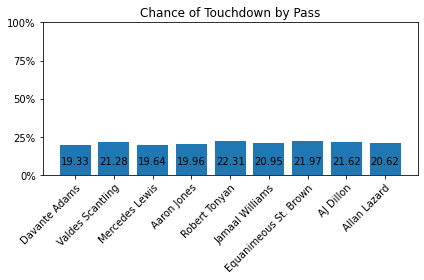

In [27]:
# Passing Plots
x = range(len(sample_passes))
y = probabilities_pass[:, 1]

plt.bar(x, y * 100, align="center")
plt.yticks(np.arange(0, 101, 25), ("0%", "25%", "50%", "75%", "100%"))
plt.xticks(np.arange(9), ("Davante Adams", "Valdes Scantling", "Mercedes Lewis", "Aaron Jones",
                          "Robert Tonyan", "Jamaal Williams", "Equanimeous St. Brown", "AJ Dillon", 'Allan Lazard'),
           rotation=45, ha='right', rotation_mode='anchor')

for xd,yd in zip(x,y):

    label = "{:.2f}".format(yd * 100)

    plt.annotate(label, # this is the text
                 (xd,yd), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.title("Chance of Touchdown by Pass")

plt.tight_layout()
plt.show()

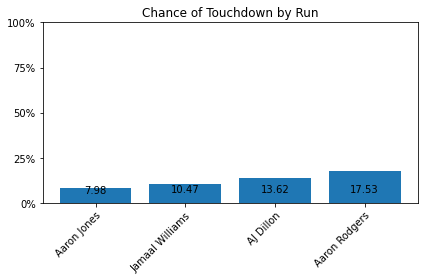

In [28]:
# Running Plots

x_2 = range(len(sample_runs))
y_2 = probabilities_run[:, 1]

plt.bar(x_2, y_2 * 100, align="center")
plt.yticks(np.arange(0, 101, 25), ("0%", "25%", "50%", "75%", "100%"))
plt.xticks(np.arange(4), ( "Aaron Jones", "Jamaal Williams","AJ Dillon", 'Aaron Rodgers'),
           rotation=45, ha='right', rotation_mode='anchor')
plt.title("Chance of Touchdown by Run")

for xr,yr in zip(x_2,y_2):

    label = "{:.2f}".format(yr * 100)

    plt.annotate(label, # this is the text
                 (xr,yr), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.tight_layout()
plt.show()

# Conclusions

* The best option for a pass is to Robert Tonyan, who has a touchdown likelyhood of 23%.
* The best option for a run is for Aaron Rodgers to keep it himself and go for it, with a touchdown likelyhood of 18%

* Over the last two seasons, Davante Adams has been the best wide-receiver in the NFL, so passing to him would be extremely likely, however the defense would know this so spreading the ball to another trusted receiver would make some sense here.

* An attempeted run would have been extremely unlikely here, and the above predictions show why. Aaron Rodgers being the highest predicted makes some sense but it would have required a pass play to have been called, and no receivers to have been open. Rodgers is good at these so the Bucc's probably would have designated a player to watch him.

So if I was Matt LeFluer would I have have kicked the field goal as well after looking at these results ? 
No.

The score was 31-23, so after taking the field goal, the Packers defense needed to stop the Buccs in getting a first down to seal the game, and then go down and score a touchdown as another field goal wouldn't have sufficed. The Packers struggled to contain the Buccs for most of the game, and defense wasnt their strong point all year.

To me, the question should have been do we go for two on the extra point from the touchdown. Maybe that can be my next analysis. 

But the main reason the Packers should have gone for it there and then is because of one man...

## Aaron Rodgers

since...


![ChessUrl](https://c.tenor.com/JWy_yYA7vTQAAAAC/aaron-rodgers-bad-man.gif "chess")